In [1]:
import numpy as np
import os, re
from Data import dataExp
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM, TextDataset, DataCollatorForLanguageModeling
from tensor2tensor.data_generators import text_encoder

torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [26]:
# Define the number of training epochs
num_epochs = 100

# Define the batch size
batch_size = 8

# Define lists for storing the training and validation losses
train_loss_step = []
train_loss_epoch = []

log_interval = 20
author = "Vergil"

In [17]:
CI = dataExp.CorpusInterface(corpus_name="tokenized_corpus.pickle", shouldTokenize = True)
text = CI.get_text_for_author(author=author,shouldShuffle=True)

Found the existing corpus
abbofloracensis had 1 pieces of work with a total of 5403 characters of text
abelard had 1 pieces of work with a total of 13784 characters of text
acticussincerius had 1 pieces of work with a total of 340 characters of text
addison had 1 pieces of work with a total of 296 characters of text
adso had 1 pieces of work with a total of 2351 characters of text
aelredus had 1 pieces of work with a total of 20901 characters of text
agnes had 1 pieces of work with a total of 11811 characters of text
alanus had 1 pieces of work with a total of 34012 characters of text
albericodamarcellise had 1 pieces of work with a total of 27 characters of text
albertanus had 1 pieces of work with a total of 2869 characters of text
albertofaix had 1 pieces of work with a total of 14123 characters of text
alcuin had 1 pieces of work with a total of 487 characters of text
aleandrogerolamo had 1 pieces of work with a total of 654 characters of text
alfonsi had 1 pieces of work with a to

In [18]:
with open(f"{author}_data.txt","w+") as f:
    f.write(text)

In [25]:
path_to_latin_bert = "./LatinBERT/"
tokenizer = AutoTokenizer.from_pretrained(path_to_latin_bert)
model = AutoModelForMaskedLM.from_pretrained(path_to_latin_bert+"latin_bert/")
model.to(device)

Some weights of the model checkpoint at ./LatinBERT/latin_bert/ were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32900, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [4]:
# Tokenize the text data
encoded_data = tokenizer(text, return_tensors='pt')

Token indices sequence length is longer than the specified maximum sequence length for this model (137874 > 512). Running this sequence through the model will result in indexing errors


In [64]:
def collate_fn(batch):
    input_ids = torch.stack([torch.tensor(item[0]) for item in batch])
    attention_mask = torch.stack([torch.tensor(item[1]) for item in batch])
    labels = torch.stack([torch.tensor(item[2]) for item in batch])

    # Move data to the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)

    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}


In [27]:
from torch.utils.data import DataLoader
# Define the dataset and data collator for training the model
dataset = TextDataset(file_path=f"{author}_data.txt", tokenizer=tokenizer, block_size=256)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.35)
train_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)

Token indices sequence length is longer than the specified maximum sequence length for this model (153103 > 512). Running this sequence through the model will result in indexing errors


In [11]:
import pickle
def save_object(obj, filename):
    with open(filename, "wb") as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

save_object(dataset, f"{author}_dataset.pickle")

In [28]:
# Define the optimizer and learning rate scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)


In [29]:
torch.cuda.empty_cache()

# Train the model
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    
    for step, batch in enumerate(train_dataloader):
        # forward pass
        #print(batch["input_ids"].size())
        #batch["input_ids"].to(device)
        #batch['labels'].to(device)
        
        outputs = model(input_ids=batch['input_ids'].to(device),labels=batch['labels'].to(device))
        loss = outputs.loss
        
        # backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_loss_step.append(loss.item())
        
        # log training progress
        if (step + 1) % log_interval == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}] Step [{step + 1}/{len(train_dataloader)}]: Train loss = {train_loss / log_interval}")
            train_loss = 0
            
    train_loss_epoch.append(train_loss / len(train_dataloader))

Epoch [1/100] Step [20/76]: Train loss = 4.014745211601257
Epoch [1/100] Step [40/76]: Train loss = 3.675381600856781
Epoch [1/100] Step [60/76]: Train loss = 3.4821263790130614
Epoch [2/100] Step [20/76]: Train loss = 3.2124864220619203
Epoch [2/100] Step [40/76]: Train loss = 3.2662423729896544
Epoch [2/100] Step [60/76]: Train loss = 3.2718044996261595
Epoch [3/100] Step [20/76]: Train loss = 2.970938432216644
Epoch [3/100] Step [40/76]: Train loss = 3.162355887889862
Epoch [3/100] Step [60/76]: Train loss = 3.044916343688965
Epoch [4/100] Step [20/76]: Train loss = 2.8411155462265016
Epoch [4/100] Step [40/76]: Train loss = 2.9731759786605836
Epoch [4/100] Step [60/76]: Train loss = 3.0320129871368406
Epoch [5/100] Step [20/76]: Train loss = 2.8337814927101137
Epoch [5/100] Step [40/76]: Train loss = 2.8598729610443114
Epoch [5/100] Step [60/76]: Train loss = 2.8792396426200866
Epoch [6/100] Step [20/76]: Train loss = 2.753835904598236
Epoch [6/100] Step [40/76]: Train loss = 2.811

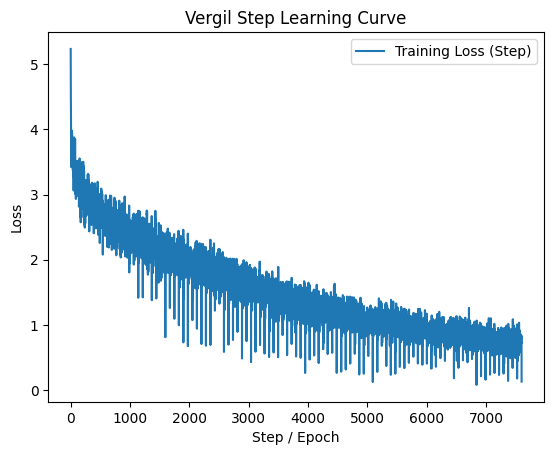

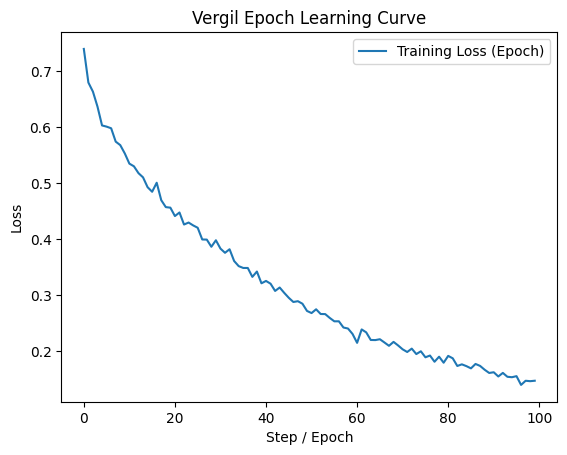

In [30]:
# plot learning curve
import matplotlib.pyplot as plt

plt.plot(train_loss_step, label='Training Loss (Step)')
plt.xlabel('Step / Epoch')
plt.ylabel('Loss')
plt.title(f"{author} Step Learning Curve")
plt.legend()
plt.savefig(f"learning_curves/{author}_Step_Learning_Curve.png")
plt.show()
plt.plot(train_loss_epoch, label='Training Loss (Epoch)')
plt.xlabel('Step / Epoch')
plt.ylabel('Loss')
plt.title(f"{author} Epoch Learning Curve")
plt.legend()
plt.savefig(f"learning_curves/{author}_Epoch_Learning_Curve.png")
plt.show()

In [31]:
model.save_pretrained(f"./{author}-finetuned/")

In [39]:
input_text = ""
input_ids = tokenizer.encode(input_text, return_tensors='pt')
outputs = model.generate(input_ids=input_ids.to(device), max_length=50, do_sample=True)
predicted_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(predicted_text)

. o. o. c volo dico. - - - sed concedo. volo et ego volo. c pater et tu volo idem sum punc tu oro unus sum volo bonus pater punc meus tu quoque pars in regnum meo loco.


In [38]:
tokenizer.convert_ids_to_tokens(tokenizer.encode("punc"))

['[CLS]', 'pun', 'c_', '[SEP]']